# Example 5

The aim of this notebook is to go forward in the analysis performed by Audrey BROUILLET (IRD) : we perform simulations for millet in Niger from years 1981-2021 and compute different indices, such as beginning of season, end of season, season length, water-stress related indices, and atteinable yield.

## Imports

In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import io
import xarray as xr
from sarra_py import *
import time
import geopandas as gpd

 ## Analysis parameters

In [2]:
# weather and rainfall data path
rainfall_data_paths = {
                        "CHIRPS" : "/mnt/d/climate_database/CHIRPS_v2.0_Africa_niger/", # 1981-2022
                        "TAMSAT" : "/mnt/d/climate_database/TAMSAT_v3.1_niger_rfe_filled_1983_2021_DL20230614/" # 1983-2021
                      }
climate_data_path = "/mnt/d/climate_database/AgERA5_niger_1981_2021_DL20230615/" # 1981-2021

# parameter files
file_paramVariete = "millet_variety_exemple5.yaml"
file_paramITK = "millet_exemple5.yaml"
file_paramTypeSol = "exemple5.yaml"

# parameters for time series analysis
year_start = 1981
year_end = 2021
duration = 365 # we load all days of the year for this analysis
dataset = "CHIRPS"

In [3]:
# we start by loading the estimated sowing dates, previously produced for CHIRPS and TAMSAT

# listing the result files
path = "./exemple_3_sowing_date_timeseries/"+dataset+"/"
files = os.listdir(path)
files.sort()

years = [int(file.split(".")[0]) for file in files]

# Defining functions

In [4]:
def save_figure(variable, dataset, year):
        if not os.path.exists("./exemple_5/{}/".format(variable)):
                os.makedirs("./exemple_5/{}/".format(variable), exist_ok=True)

        data[variable].astype('float32').rio.to_raster("./exemple_5/{}/{}_{}_{}.tif".format(variable, variable, dataset, year))

def calc_anomalies(variable, data, zscore_thresh):
        data[variable+"_in_season"] = xr.where(data["time"] >= data["date_begin_season"],
                xr.where(data["time"] <= data["date_end_season"],
                        data[variable],
                        np.nan),
                np.nan)

        data[variable+"_in_season_mean"] = data[variable+"_in_season"].mean(dim="time")
        data[variable+"_in_season_std"] = data[variable+"_in_season"].std(dim="time")
        data[variable+"_in_season_zscore"] = (data[variable+"_in_season"] - data[variable+"_in_season_mean"]) / data[variable+"_in_season_std"]
        #data[variable+"_in_season_zscore"].plot()
        data[variable+"_in_season_anomaly_pos"] = xr.where(data[variable+"_in_season_zscore"] > zscore_thresh, 1, 0)
        #data[variable+"_in_season_anomaly_pos"].sum(dim="time").plot()
        #plt.show()
        data[variable+"_in_season_anomaly_neg"] = xr.where(data[variable+"_in_season_zscore"] < -zscore_thresh, 1, 0)
        #data[variable+"_in_season_anomaly_neg"].sum(dim="time").plot()
        #plt.show()

        return data


# performing the analysis by running the model

In [5]:
year_start = 1989
year_end = 1990

for year_id in tqdm(range(year_start - 1981,year_end-1981)):
# for year_id in tqdm(range(1992)):
    #try:
        year = years[year_id]

        print("year",str(year))
        # defining date of simulation start and simulation length in days
        date_start = datetime.date(year,1,1)

        # retrieving the grid size from the rainfall data (this method will be deprecated in the future)
        rainfall_data_path = rainfall_data_paths[dataset]
        grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration)

        ## preparing the base dataset
        # initialize empty xarray dataset to load base data
        base_data = xr.Dataset()

        # load rainfall and weather data
        base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration)
        base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration)

        # load soil data using the iSDA method (uses more recent maps)
        base_data = load_iSDA_soil_data_alternate(base_data, grid_width, grid_height)

        # compute the day lengthµ
        base_data = calc_day_length_raster_fast(base_data, date_start, duration)

        ## prepating simulation dataset
        # load variety, cropping system and soil parameters
        paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)
        paramITK["DateSemis"] = datetime.date(year,4,1)

        
        # creating simulation xarray dataset by copying the base data
        data = base_data.copy()

        # initializing all the necessary variables
        data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
        data = initialize_default_irrigation(data)
        data = calculate_once_daily_thermal_time(data, paramVariete)

        ## running the model
        data = run_model(paramVariete, paramITK, paramTypeSol, data, duration)

        """




        

        verbose=False

        # calculating date of end of season
        argmax = ((data["numPhase"]==7) & (data["changePhase"]==1)).argmax(axis=0)
        data["date_end_season"] = xr.where(argmax==0, np.nan, argmax)
        if verbose :
                data["date_end_season"].plot()
                plt.title("date_end_season")
                plt.show()
        # plt.hist(data["date_end_season"].values.flatten())
        # plt.show()

        # saving end of season
        variable = "date_end_season"
        save_figure(variable, dataset, year)


        # calculating beginning of season
        argmax = ((data["numPhase"]==1) & (data["changePhase"]==1)).argmax(axis=0)
        data["date_begin_season"] = xr.where(argmax==0, np.nan, argmax)
        if verbose :
                data["date_begin_season"].plot()
                plt.title("date_begin_season")
                plt.show()
        # plt.hist(data["date_begin_season"].values.flatten())
        # plt.show()

        # saving beginning of season
        variable = "date_begin_season"
        save_figure(variable, dataset, year)


        # calculating duration of season
        data["season_length"] = data["date_end_season"] - data["date_begin_season"]
        if verbose :
                data["season_length"].plot()
                plt.title("season_length")
                plt.show()
        # plt.hist(data["season_length"].values.flatten())
        # plt.show()

        # saving duration of season
        variable = "season_length"
        save_figure(variable, dataset, year)





        # calculating cstr related variables
        variable = "cstr"
        zscore_thresh = 2.5
        data = calc_anomalies(variable, data, zscore_thresh)

        # calculating number of days in season under cstr thres
        cstr_thres=0.5
        data["days_under_cstr_thres"] = xr.where(((data["cstr_in_season"]<cstr_thres).sum(axis=0))==0,np.nan,(data["cstr_in_season"]<cstr_thres).sum(axis=0))
        if verbose :
                data["days_under_cstr_thres"].plot()
                plt.title("days_under_cstr_thres")
                plt.show()

        # saving number of days in season under cstr thres
        variable = "days_under_cstr_thres"
        save_figure(variable, dataset, year)


        # calculating in season mean value for cstr
        # (already calculated via calc_anomalies)
        if verbose :
                data["cstr_in_season_mean"].plot()
                plt.title("cstr_in_season_mean")
                plt.show()

        # saving in season mean value for cstr
        variable = "cstr_in_season_mean"
        save_figure(variable, dataset, year)


        # calculating yield
        data["yield"] = xr.where(data["rdt"][-1,:,:]==0,np.nan,data["rdt"][-1,:,:])
        if verbose :
                data["yield"].plot()
                plt.title("yield")
                plt.show()

        # saving yield
        variable = "yield"
        save_figure(variable, dataset, year)






        

        # del data
        # del base_data
    #except:
    #    print("issue with year",str(year))
    """
    


  0%|          | 0/1 [00:00<?, ?it/s]

year 1989


100%|██████████| 1/1 [10:38<00:00, 638.39s/it]


In [6]:
paramITK["DateSemis"]

datetime.date(1989, 4, 1)

In [7]:
year

1989

In [8]:
base_data

<xarray.Dataset>
Dimensions:           (x: 329, y: 251, time: 365)
Coordinates:
  * x                 (x) float64 -0.525 -0.475 -0.425 ... 15.78 15.83 15.88
  * y                 (y) float64 23.82 23.77 23.72 23.67 ... 11.42 11.37 11.32
    spatial_ref       int64 0
Dimensions without coordinates: time
Data variables: (12/13)
    rain              (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tpMoy             (time, y, x) float32 nan nan nan nan ... 24.95 24.95 24.87
    ET0               (time, y, x) float32 nan nan nan nan ... 3.562 3.562 3.507
    rg                (time, y, x) float32 nan nan nan nan ... 2.157 2.157 2.16
    profRu            (y, x) float32 nan nan nan nan ... 400.0 400.0 750.0 400.0
    epaisseurSurf     (y, x) float32 200.0 200.0 200.0 ... 200.0 200.0 200.0
    ...                ...
    soil_type         (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 6.0 6.0 6.0 6.0 6.0
    runoff_threshold  (y, x) float32 nan nan nan nan nan ... 15.0 15.0 15.0 15.0
    runoff_rate       (y, x) float32 nan nan nan nan nan ... 0.35 0.35 0.35 0.35
    RZPAWC            (y, x) float32 nan nan nan nan nan ... 30.0 34.0 52.0 30.0
    ru                (y, x) float32 nan nan nan nan ... 75.0 85.0 69.33 75.0
    dureeDuJour       (time, y, x) float64 10.69 10.69 10.69 ... 11.47 11.47

In [9]:
data

<xarray.Dataset>
Dimensions:                      (x: 329, y: 251, time: 365)
Coordinates:
  * x                            (x) float64 -0.525 -0.475 ... 15.83 15.88
  * y                            (y) float64 23.82 23.77 23.72 ... 11.37 11.32
    spatial_ref                  int64 0
Dimensions without coordinates: time
Data variables: (12/113)
    rain                         (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    tpMoy                        (time, y, x) float32 nan nan ... 24.95 24.87
    ET0                          (time, y, x) float32 nan nan ... 3.562 3.507
    rg                           (time, y, x) float32 nan nan nan ... 2.157 2.16
    profRu                       (y, x) float32 nan nan nan ... 750.0 400.0
    epaisseurSurf                (y, x) float32 200.0 200.0 ... 200.0 200.0
    ...                           ...
    sumPP                        (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    TigeUp                       (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    UBTCulture                   (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    lai                          (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    Ncrit                        (time, y, x) float32 nan nan ... 208.2 217.0
    irrigation                   (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0

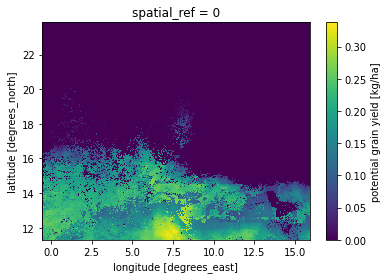

In [11]:
data["rdtPot"][-1,:,:].plot()